<a href="https://colab.research.google.com/github/K532001/Computer-Vision/blob/main/Garg_Kunal_115362488_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE527 Homework 2
**Due date: 23:59 on October 29, 2023 (Sunday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org).

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 114 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 90% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all.

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

For Problem 3 you will train a small Vision Transformer (ViT) from scratch. ViT is pre-trained on large amounts of
data and transferred to multiple mid-sized or small image recognition benchmarks(ImageNet, CIFAR-100, VTAB, etc.), ViT attains excellent results compared to state-of-the-art convolutional networks.

There are 3 problems in this homework with a total of 100 points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/drive/folders/1-0wI50GfpXl3Dcxo2vjvItbnHMDdVurU?usp=drive_link) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [ ]:
# import packages here
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set your working directory (in your google drive)
#   change it to your specific homework directory.
%cd '/content/gdrive/My Drive/CSE527'

/content/gdrive/My Drive/CSE527


## Problem 0: Loading and Preprocessing data
---
In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
# split data into train and test
def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

            if is_color:
                img = np.transpose(img, [2, 0, 1])

            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)

    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation
    if augment:
        augmented_data = []
        augmented_labels = []
        for img, label in zip(data, labels):
            augmented_data.append(img)
            augmented_labels.append(label)
            # Apply horizontal mirroring
            mirrored_img = np.fliplr(img)
            augmented_data.append(mirrored_img)
            augmented_labels.append(label)

        data = augmented_data
        labels = augmented_labels


    ##########-------END OF CODE-------##########

    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
        data_mean = np.mean(data)
        # Subtract the mean from each image
        data = [img - data_mean for img in data]

    ##########-------END OF CODE-------##########

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)

    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []

        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels

    return zip(batch_data, batch_labels)

class_names: {0: 'viola_striata', 1: 'vaccinium_stamineum', 2: 'rubus_phoenicolasius', 3: 'smilax_glauca', 4: 'ranunculus_recurvatus', 5: 'quercus_montana', 6: 'phlox_divaricata', 7: 'ostrya_virginiana', 8: 'lindera_benzoin', 9: 'heliopsis_helianthoides', 10: 'lonicera_maackii', 11: 'liriodendron_tulipifera', 12: 'ilex_opaca', 13: 'juniperis_virginiana', 14: 'humulus_japonicus', 15: 'lysimachia_nummularia', 16: 'glechoma_hederacea', 17: 'eupatorium_coalestinum', 18: 'asclepias_incarnata', 19: 'celastrus_orbiculatus', 20: 'ailanthus_altissima', 21: 'campsis_radicans'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


<ipython-input-4-1bc1ec93ec51>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 7 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from cla

asclepias_incarnata


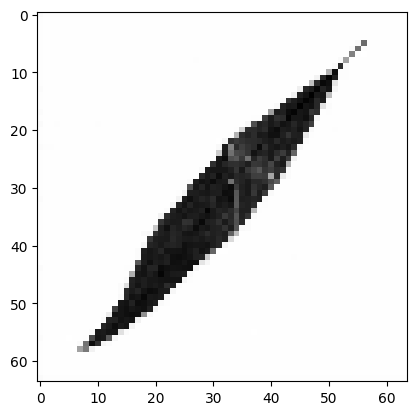

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch [40 points]
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()

      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4),
      )

      self.classifier = nn.Sequential(
         nn.Linear(3600, 22),
      )

    def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x


Then, let's define model training and evaluation functions.

In [ ]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time

def trainModel(net, trainloader, train_option, testloader=None):
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1

  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()

  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))

    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [ ]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time

def evalModel(net, testloader):
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()

  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)

  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))


Finally, let's start training and evaluation.

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:01 | Train Loss: 3.0894 | Average Loss: 3.0894 
Accuracy: 0.000000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.7661 | Average Loss: 3.2171 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.3866 | Average Loss: 2.9037 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.7658 | Average Loss: 2.6726 
Accuracy: 0.468750 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.5092 | Average Loss: 2.4751 
Accuracy: 0.468750 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.3366 | Average Loss: 2.2901 
Accuracy: 0.562500 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.0746 | Average Loss: 2.1196 
Accuracy: 0.656250 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.8557 | Average Loss: 1.9649 
Accuracy: 0.656250 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:01 |

You would get around 0.45-0.55 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1 [25 points]
Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 114 original training images as much (because it sees 228 training images now, although they're not as good as 228 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The reported accuracy required for this section should exceed **0.60**. As the dataset is small and there may be overfitting, your can report the **largest** accuracy achieved during training epoches.

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13


<ipython-input-4-1bc1ec93ec51>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 14 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 2 minibatches (batch_size=16

In [ ]:
class EnhancedTNet(nn.Module):
    def __init__(self):
        super(EnhancedTNet, self).__init__()

        # Define the layers
        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
            nn.Dropout(0.5)  # Add dropout after max pooling
        )

        self.classifier = nn.Sequential(
            nn.Linear(3600, 1000),  # Add an additional dense layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(1000, 22)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


enhanced_net = EnhancedTNet()


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
EnhancedTNet_net = EnhancedTNet()
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(EnhancedTNet_net, trainloader_small, train_option, testloader_small)
evalModel(EnhancedTNet_net,  testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0657 | Average Loss: 3.0657 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.9098 | Average Loss: 3.0291 
Accuracy: 0.437500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.2591 | Average Loss: 2.5928 
Accuracy: 0.562500 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.7155 | Average Loss: 2.2029 
Accuracy: 0.625000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.6635 | Average Loss: 1.8845 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.2634 | Average Loss: 1.6340 
Accuracy: 0.531250 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.2936 | Average Loss: 1.4283 
Accuracy: 0.593750 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.4631 | Average Loss: 1.2707 
Accuracy: 0.593750 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:00 |

Answer:

Data augmentation: Horizontal flipping with a 50% probability.
Random rotation within [-15, 15] degrees.

Data normalization: Zero-centre

Layer 1: Convolutional Layer: 16 filters, 3x3 kernel, with ReLU activation.
Layer 2: Max Pooling Layer: 4x4 kernel, stride of 4.
Layer 3: Dropout Layer: 50% dropout rate for regularization.
Layer 4: Fully Connected Layer: 3600 input features, 1000 output features, with ReLU activation.
Layer 5: Dropout Layer: 50% dropout rate for regularization.
Layer 6: Output Layer: 1000 input features, 22 output features.


Accuray on Test set: 0.718750 (Epoch 18) | Time for Training: 00:00:01 | Time for Testing: 00:00:00


## Problem 1.2 [15 points]

Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The reported accuracy required for this section should exceed **0.70**. Your can report the **largest** accuracy achieved during training epoches.(At least **TWO** Technique should achieve this).

### Technique 1

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13


<ipython-input-4-1bc1ec93ec51>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 14 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 2 minibatches (batch_size=16

In [ ]:
class TechniqueNet1(nn.Module):
    def __init__(self):
        super(TechniqueNet1, self).__init__()

        # Feature extraction layers
        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
            nn.Conv2d(32, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=3),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 212),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(212, 22)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# Define the TechniqueNet1 model
TechniqueNet1_net = TechniqueNet1().to(device)

# Define the training options
train_option = {}
train_option['lr'] = 0.003
train_option['epoch'] = 40
train_option['device'] = 'gpu'
train_option['log_iter'] = 10

# Train and evaluate the TechniqueNet1 model
trainModel(TechniqueNet1_net, trainloader_small, train_option, testloader_small)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0776 | Average Loss: 3.0776 
Epoch: 1 | Iter:   10 | Time: 00:00:00 | Train Loss: 3.0599 | Average Loss: 3.1152 
Accuracy: 0.062500 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9874 | Average Loss: 3.0989 
Epoch: 2 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.8046 | Average Loss: 3.0371 
Accuracy: 0.093750 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8413 | Average Loss: 3.0226 
Epoch: 3 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.5797 | Average Loss: 2.9642 
Accuracy: 0.218750 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7770 | Average Loss: 2.9491 
Epoch: 4 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.3959 | Average Loss: 2.8527 
Accuracy: 0.281250 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.1533 | Average Loss: 2.8272 
Epoch: 5 | Iter:   10 | Time: 00:00:00 | Train Loss: 2.1559 | Average Loss: 2.7472 
Accuracy: 0.4062

Answer:

Method 1: I have changed pooling stratedgy, used regularization and modified the classification layer.

Accuracy: 0.7500000 Time: 00:00:02

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=False, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6


<ipython-input-4-1bc1ec93ec51>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 7 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images fr

In [ ]:
class TechniqueNet2(nn.Module):
    def __init__(self):
        super(TechniqueNet2, self).__init__()

        # Feature extraction layers
        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(4, stride=4),

            nn.Conv2d(32, 16, 3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(3, stride=3),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 212),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(212, 22)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
TechniqueNet2_net = TechniqueNet2()
train_option = {}
train_option['lr'] = 0.003
train_option['epoch'] = 30
train_option['device'] = 'gpu'
trainModel(TechniqueNet2_net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.2599 | Average Loss: 3.2599 
Accuracy: 0.125000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.6890 | Average Loss: 3.2849 
Accuracy: 0.062500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9160 | Average Loss: 3.0402 
Accuracy: 0.093750 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.2114 | Average Loss: 2.8393 
Accuracy: 0.062500 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3488 | Average Loss: 2.6326 
Accuracy: 0.093750 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3594 | Average Loss: 2.4476 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.6129 | Average Loss: 2.2939 
Accuracy: 0.218750 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.0505 | Average Loss: 2.1388 
Accuracy: 0.281250 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:00 |

Answer:

Method 2: Changed the activation function to leakyReLU.

Accuracy on test data: 0.718750  (compare with 0.6500 in vanilla network)

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

# load data into size (64, 64)
img_size = (64, 64)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11


<ipython-input-29-56128e21642c>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 14 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading image

In [ ]:
class TechniqueNet3(nn.Module):
    def __init__(self):
        super(TechniqueNet3, self).__init__()

        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 22)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:

#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
TechniqueNet3_net = TechniqueNet3()
train_option = {}
train_option['lr'] = 0.004
train_option['epoch'] = 30
train_option['device'] = 'gpu'
set_random_seed(0)
trainModel(TechniqueNet3_net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.2541 | Average Loss: 3.2541 
Accuracy: 0.125000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7096 | Average Loss: 3.0494 
Accuracy: 0.312500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.2934 | Average Loss: 2.7685 
Accuracy: 0.125000 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.0035 | Average Loss: 2.5863 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.7829 | Average Loss: 2.4330 
Accuracy: 0.218750 | Time: 00:00:00
Epoch: 6 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.6156 | Average Loss: 2.3148 
Accuracy: 0.250000 | Time: 00:00:00
Epoch: 7 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.5337 | Average Loss: 2.1889 
Accuracy: 0.531250 | Time: 00:00:00
Epoch: 8 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3666 | Average Loss: 2.0899 
Accuracy: 0.531250 | Time: 00:00:00
Epoch: 9 | Iter:    0 | Time: 00:00:00 |

Answer:

Method 3: I have changed the activation function to leakyreLU, applied batch normalization too along with it. I have also added a dropout rate.

Accuracy on test data:  0.718750 epoch 28 (compare with 0.6500 in vanilla network)

## Problem 2: Fine Tuning a Pre-Trained Deep Network [30 points]
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks.

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1 [10 points]

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 22 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(30 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.90** approximately. The minimum accuracy required for this section is **0.80**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 16 # training sample number per batch

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True,
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7


<ipython-input-4-1bc1ec93ec51>:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.append(img.astype(np.float)/255*2-1)


Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images from class: 17
Loading images from class: 18
Loading images from class: 19
Loading images from class: 20
Loading images from class: 21
Finish loading 14 minibatches (batch_size=16) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 16
Loading images 

In [ ]:
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable

# Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)

# Freeze the layers except the last convolutional block and the classifier
for param in alexnet.features[:10].parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = alexnet.classifier[6].in_features
new_classifier = nn.Sequential(*[alexnet.classifier[i] for i in range(6)])
new_classifier.add_module("6", nn.Dropout(p=0.5))
new_classifier.add_module("7", nn.Linear(num_ftrs, 22))
alexnet.classifier = new_classifier

# Training options
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 30
train_option['device'] = 'gpu'
train_option['log_iter'] = 10
train_option['weight_decay'] = 5e-4
set_random_seed(0)

# Train the model
trainModel(alexnet, trainloader_large, train_option, testloader_large)
evalModel(alexnet, testloader_large)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.4277 | Average Loss: 3.4277 
Epoch: 1 | Iter:   10 | Time: 00:00:00 | Train Loss: 1.0699 | Average Loss: 2.3729 
Accuracy: 0.625000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.6488 | Average Loss: 2.0062 
Epoch: 2 | Iter:   10 | Time: 00:00:00 | Train Loss: 0.3259 | Average Loss: 1.4976 
Accuracy: 0.812500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.0702 | Average Loss: 1.3295 
Epoch: 3 | Iter:   10 | Time: 00:00:01 | Train Loss: 0.1109 | Average Loss: 1.0583 
Accuracy: 0.812500 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.0640 | Average Loss: 0.9741 
Epoch: 4 | Iter:   10 | Time: 00:00:01 | Train Loss: 0.0217 | Average Loss: 0.8317 
Accuracy: 0.812500 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.4137 | Average Loss: 0.7852 
Epoch: 5 | Iter:   10 | Time: 00:00:02 | Train Loss: 0.0221 | Average Loss: 0.7002 
Accuracy: 0.7812

Answer:

(1) which layers of AlexNet have been replaced



(2) the architecture of the new layers added including activation methods (same as problem 1)

Data augmentation: horizontal flips have been used

Data normalization: data has been normalized used zero-centring

Classifier Layer 1: Layer retained

Classifier Layer 2: Dropout layer with a probability of
p=0.5 was added.

Classifier Layer 3: fully connected layer (Linear) with an output of 22 nodes (for the 22 classes)

...

(3) the final accuracy on test set along with time consumption for both training and testing

Accuracy on Test set: 0.84370 | Time for Training: 00:00:11 | Time for Testing: 00:0012




### Problem 2.2 [10 points]
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(20 points) Implement Strategy B where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

In [ ]:
# Loading a Pre-trained AlexNet
alexnet_model = models.alexnet(pretrained=True)

# Determining if CUDA is available...
compute_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fetch_deep_features(network, data_loader):
    """
    Extracts features from a given network.

    Args:
    - network (torch.nn.Module): A pretrained model to extract features from.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.

    Returns:
    - deep_features (np.array): Extracted features.
    - labels_list (np.array): Corresponding labels.
    """
    deep_features = []
    labels_list = []

    for batch_data, batch_labels in data_loader:
        data = batch_data.float().to(compute_device)
        labels = batch_labels.float().to(compute_device)

        with torch.no_grad():
            output = network.features(data)

        deep_features.append(output.cpu().numpy().reshape(len(data), -1))
        labels_list.extend(list(labels.cpu().numpy()))

    deep_features = np.vstack(deep_features)
    labels_list = np.array(labels_list)

    return deep_features, labels_list

# Transfer the model to thegpu
alexnet_model = alexnet_model.to(compute_device)

# Extract features using the model
train_deep_features, train_labels_array = fetch_deep_features(alexnet_model, trainloader_large)
test_deep_features, test_labels_array = fetch_deep_features(alexnet_model, testloader_large)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Importing necessary libraries
from sklearn.svm import SVC
import time

def train_evaluate_SVM(features_train, labels_train, features_test, labels_test):
    """
    Trains an SVM on the provided training features and evaluates it on both training and test sets.

    Args:
    - features_train (np.array): Training features.
    - labels_train (np.array): Training labels.
    - features_test (np.array): Test features.
    - labels_test (np.array): Test labels.

    Returns:
    - train_accuracy (float): Accuracy on the training set.
    - test_accuracy (float): Accuracy on the test set.
    - training_time (str): Time taken for training.
    - testing_time (str): Time taken for testing.
    """
    # Create and train the SVM classifier
    classifier = SVC(kernel='rbf')
    start_time = time.time()
    classifier.fit(features_train, labels_train)
    mid_time = time.time()

    # Predict labels for both training and test sets
    train_predicted_labels = classifier.predict(features_train)
    end_train_time = time.time()
    test_predicted_labels = classifier.predict(features_test)
    end_time = time.time()

    # Calculate accuracies
    train_accuracy = np.mean(train_predicted_labels == labels_train)
    test_accuracy = np.mean(test_predicted_labels == labels_test)

    # Calculate time taken for training and testing
    training_time = time.strftime('%H:%M:%S', time.gmtime(mid_time - start_time))
    testing_time = time.strftime('%H:%M:%S', time.gmtime(end_time - end_train_time))

    return train_accuracy, test_accuracy, training_time, testing_time

# Training and evaluating SVM
train_acc, test_acc, train_time, eval_time = train_evaluate_SVM(train_deep_features, train_labels_array, test_deep_features, test_labels_array)

print("Accuracy of SVM (using AlexNet features) on training data:", train_acc, "| Training Time:", train_time)
print("Accuracy of SVM (using AlexNet features) on test data:", test_acc, "| Testing Time:", eval_time)



Accuracy of SVM (using AlexNet features) on training data: 0.9821428571428571 | Training Time: 00:00:00
Accuracy of SVM (using AlexNet features) on test data: 0.8125 | Testing Time: 00:00:00


### Problem 2.3 [10 points]

Now fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. **Explain** why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

import torchvision.models as models

# Load pre-trained ResNet50
resnet50 = models.resnet50(pretrained=True)

# Modify its architecture: replace the final fully connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 22)

# Ensure the model is in training mode
resnet50.train()

# Define the training options
train_option_resnet = {}
train_option_resnet['lr'] = 0.001  # Use a smaller learning rate for fine-tuning
train_option_resnet['epoch'] = 30
train_option_resnet['device'] = 'gpu'
train_option_resnet['log_iter'] = 10

trainModel(resnet50, trainloader_large, train_option, testloader_large)
evalModel(resnet50, testloader_large)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 3.0865 | Average Loss: 3.0865 
Epoch: 1 | Iter:   10 | Time: 00:00:02 | Train Loss: 1.5192 | Average Loss: 2.5884 
Accuracy: 0.062500 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:02 | Train Loss: 1.1866 | Average Loss: 2.3210 
Epoch: 2 | Iter:   10 | Time: 00:00:04 | Train Loss: 1.1384 | Average Loss: 1.9836 
Accuracy: 0.531250 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:05 | Train Loss: 0.8239 | Average Loss: 1.8495 
Epoch: 3 | Iter:   10 | Time: 00:00:06 | Train Loss: 0.7024 | Average Loss: 1.5774 
Accuracy: 0.500000 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:07 | Train Loss: 0.3745 | Average Loss: 1.4726 
Epoch: 4 | Iter:   10 | Time: 00:00:09 | Train Loss: 0.6740 | Average Loss: 1.3033 
Accuracy: 0.406250 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:10 | Train Loss: 0.3597 | Average Loss: 1.2536 
Epoch: 5 | Iter:   10 | Time: 00:00:11 | Train Loss: 0.2991 | Average Loss: 1.1128 
Accuracy: 0.6250

Answer:

Accuracy on Test set: 0.906250  | Time for Training: 00:01:56| Time for Testing: 00;00:00

(compare with xxx in AlexNet)

(1) Which layers of ResNet-50 have been replaced?
The final fully connected layer of ResNet-50, which originally had 1000 output features (one for each ImageNet class), has been replaced to match the number of classes in dataset (22 classes).


(2) ResNet has performed better since, ResNet-50, with its 50 layers deep architecture, can capture more complex features compared to AlexNet. The residual connections in ResNet help combat the vanishing gradient problem, allowing for the training of such deep networks.

Also, ResNet, or Residual Networks, introduces the concept of skip connections (or shortcuts) to ensure that the gradient can be back-propagated to earlier layers. The fundamental idea behind ResNet is introducing these shortcuts that skip one or more layers. The core advantage of a Residual Network over traditional networks is that it can train a lot deeper networks without the fear of vanishing gradients.

### Problem 3 Transformer [30 points]
In this section you are supposed to build a Vision Transformer (ViT). Transformer has achieved significant success in the field of Natural Language Processing, such as machine translation. ViT explores how to utilize transformer into computer vision tasks and attains excellent results compared to state-of-the-art convolutional networks.

Transformer paper: https://arxiv.org/pdf/1706.03762.pdf

Transformer tutorial: http://jalammar.github.io/illustrated-transformer/

ViT paper: https://openreview.net/pdf?id=YicbFdNTTy

ViT tutorial: https://www.youtube.com/watch?v=HZ4j_U3FC94




First you will build a Transformer Encoder Layer. ViT consists of multiple transformer encoder layers (i.e. the left block of the following image). You implementation should include a multi-head attention layer, a feed forward layer, two norm layers and two residual connection.

<img src="https://production-media.paperswithcode.com/method_collections/trans.jpeg" width="400">

In [ ]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self,
               embedding_dims = 128,
               dropout=0.1,
               mlp_hidden_dim = 32,
               num_heads = 2,
               ):
    super(TransformerEncoderLayer, self).__init__()

    ##########--WRITE YOUR CODE HERE--##########
    # Multi-Head Self-Attention Layer
    self.self_attn = nn.MultiheadAttention(embedding_dims, num_heads, dropout=dropout)

    # Feed-Forward Layer
    self.feed_forward = nn.Sequential(
        nn.Linear(embedding_dims, mlp_hidden_dim),
        nn.ReLU(),
        nn.Linear(mlp_hidden_dim, embedding_dims)
    )

    # Layer Normalization
    self.norm1 = nn.LayerNorm(embedding_dims)
    self.norm2 = nn.LayerNorm(embedding_dims)

    # Dropout
    self.dropout = nn.Dropout(dropout)


    ##########-------END OF CODE-------##########

  def forward(self,x):
    ##########--WRITE YOUR CODE HERE--##########
    # Multi-Head Self-Attention
    src2 = self.self_attn(x, x, x)[0]
    x = x + self.dropout(src2)

    # Layer Normalization
    x = self.norm1(x)

    # Feed-Forward
    src2 = self.feed_forward(x)
    x = x + self.dropout(src2)

    # Layer Normalization
    x = self.norm2(x)


    ##########-------END OF CODE-------##########
    return x

<img src=https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png width="400">

Then you can start a Vision Transformer. Your ViT should consist:


**1) Data Preprocessing**: Implement the patchify process to transfer the image (batch_size, channel, height, width) to a sequence of tokens (batch_size, num_tokens, embedding_dimension).


**2) Positional Encoding**

**3) Extra Learnable [CLASS] embedding**

**4) Transformer Encoder**: Construct a transformer encoder by TransformerEncoderLayer you have already built.

**5) Prediction**: Build the MLP Head and make classification.

Train your ViT on MNIST and
 - report the test accuracy
 - save your ViT model in a checkpoint file named: **./vit_trained.pt**  

The reported accuracy required for this section should exceed **0.70**.

In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size = 64,
               in_channels = 1,
               patch_size = 16,
               embedding_dims = 128,
               num_transformer_layers = 2,
               dropout = 0.1,
               mlp_hidden_dim = 128,
               num_heads = 2,
               num_classes = 22):
    super(ViT, self).__init__()
    '''
    img_size: img height and width.
    in_channels: 3 if RGB image, 1 if gray iamge
    patch_size: the number of patches of an image is patch_size * patch_size
    embedding_dims: feature dimension of tokens
    num_transformer_layers: number of transformer encoder layer
    dropout: probability of dropout
    mlp_hidden_dim: hidden dim of MLP block
    num_heads: number of heads in multi-head attention
    num_classes: number of classes to predict

    You are suggested but NOT required to use all inputs.
    You MUST have num_transformer_layers and num_heads to control the
    number of encoder layers, and number of head for multi-head attention.

    Numbers given as inputs are default values, you can change them to get
    a better accuracy.
    '''
    ##########--WRITE YOUR CODE HERE--##########
    # Calculate the number of patches
    num_patches = (img_size // patch_size) ** 2
    patch_dim = in_channels * patch_size ** 2
    self.patch_size = patch_size


    # Positional embedding
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches, embedding_dims))

    # Patch to embedding
    self.patch_to_embedding = nn.Linear(patch_dim, embedding_dims)

    # Dropout
    self.dropout = nn.Dropout(dropout)

    # Transformer Encoder Layers
    self.encoder_layers = nn.ModuleList([
        TransformerEncoderLayer(embedding_dims, dropout, mlp_hidden_dim, num_heads)
        for _ in range(num_transformer_layers)
    ])

    # Fully connected classification head
    self.fc = nn.Linear(embedding_dims, num_classes)



    ##########-------END OF CODE-------##########

  def forward(self, x):
    ##########--WRITE YOUR CODE HERE--##########
    # Reshape input to patches
    x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
    x = x.contiguous().view(x.size(0), -1, x.size(-2) * x.size(-1))

    # Project patches to embeddings
    x = self.patch_to_embedding(x)

    # Add positional embeddings
    x = x + self.positional_embedding

    # Apply dropout
    x = self.dropout(x)

    # Apply Transformer Encoder layers
    for layer in self.encoder_layers:
        x = layer(x)

    # Global average pooling
    x = x.mean(dim=1)

    # Classification head
    x = self.fc(x)



    ##########-------END OF CODE-------##########
    return x

In [ ]:
#load MNIST dataset
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

transform = ToTensor()
train_set = MNIST(root='/content/sample_data', train=True, download=True, transform=transform)
test_set = MNIST(root='/content/sample_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
# Define your ViT model
model = ViT(img_size=64, in_channels=1, patch_size=16, embedding_dims=128, num_transformer_layers=2, dropout=0.1, mlp_hidden_dim=128, num_heads=2, num_classes=22)

# Define the training options
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 20
train_option['device'] = 'gpu'

# Start training and evaluation
trainModel(model, train_loader, train_option, test_loader)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9861 | Average Loss: 2.9861 
Epoch: 1 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.0297 | Average Loss: 2.3002 
Epoch: 1 | Iter:   40 | Time: 00:00:02 | Train Loss: 1.2347 | Average Loss: 1.9337 
Epoch: 1 | Iter:   60 | Time: 00:00:03 | Train Loss: 0.9773 | Average Loss: 1.6660 
Epoch: 1 | Iter:   80 | Time: 00:00:03 | Train Loss: 0.8284 | Average Loss: 1.4866 
Epoch: 1 | Iter:  100 | Time: 00:00:04 | Train Loss: 0.7192 | Average Loss: 1.3638 
Epoch: 1 | Iter:  120 | Time: 00:00:04 | Train Loss: 0.8073 | Average Loss: 1.2682 
Epoch: 1 | Iter:  140 | Time: 00:00:05 | Train Loss: 0.8164 | Average Loss: 1.1943 
Epoch: 1 | Iter:  160 | Time: 00:00:05 | Train Loss: 0.7479 | Average Loss: 1.1367 
Epoch: 1 | Iter:  180 | Time: 00:00:06 | Train Loss: 0.6622 | Average Loss: 1.0874 
Epoch: 1 | Iter:  200 | Time: 00:00:06 | Train Loss: 0.6923 | Average Loss: 1.0434 
Epoch: 1 | Iter:  220 | Time: 00:00:07 | Train Loss: 0.7523 | Average Loss: 

## Submission guidelines
---
Download the .ipynb file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw2' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the *dataset* on brightspace due to size limit.

When submitting your .zip file through brightspace, please
-- name your .zip file as **Surname_Givenname_SBUID_hw2.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.pdf
        |---vit_trained.pt
```

For instance, student Yann LeCun should submit a zip file named "LeCun_Yann_111134567_hw2.zip" for homework2 in this structure:
```
LeCun_Yann_111134567_hw2
        |---LeCun_Yann_111134567_hw2.ipynb
        |---LeCun_Yann_111134567_hw2.pdf
        |---vit_trained.pt
```

The **Surname_Givenname_SBUID_hw*.pdf** should only include a **google shared link**. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails: **ruoyu.xue@stonybrook.edu**. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard.

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 3 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
